In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

c:\Users\lilil\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
# Define transformations for the training set
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB, 3 channels
    transforms.Resize((224, 224)),  # Resize images to 224x224 as required by ResNet
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x / 255.0),
    # transforms.Normalize((0), (1))
])


# Load the FashionMNIST dataset
dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [122]:
def intra_class_variance(features, labels):
    unique_labels = np.unique(labels)
    intra_variances = []
    class_means = []
    for label in unique_labels:
        class_features = features[labels == label]
        class_mean = class_features.mean()
        class_means.append(class_mean)
        class_variance = np.var(class_features)
        intra_variances.append(class_variance)
    
    return intra_variances, class_means

# Quantify inter-class variance
def inter_class_variance(features, labels):
    unique_labels = np.unique(labels)
    class_means = []

    for label in unique_labels:
        class_features = features[labels == label]
        class_mean = np.mean(class_features, axis=0)
        class_means.append(class_mean)

    class_means = np.array(class_means)
    return np.var(class_means, axis=0).mean()

def inter_class_variance_tsne(tsne_features, labels):
    unique_labels = np.unique(labels)
    inter_variances = {}

    for i, label1 in enumerate(unique_labels):
        for label2 in unique_labels[i + 1:]:
            pooled_features = np.vstack((tsne_features[labels == label1], tsne_features[labels == label2]))
            pairwise_variance = np.var(pooled_features, axis=0).mean()
            inter_variances[(label1, label2)] = pairwise_variance
    
    return inter_variances

def pairwise_intra_mean_diff(mean_intra):
    unique_labels = range(len(mean_intra))
    pairwise_differences = {}

    for i, label1 in enumerate(unique_labels):
        for label2 in unique_labels[i + 1:]:
            # Compute the difference between the mean_intra of the two classes
            difference = abs(mean_intra[label1] - mean_intra[label2])
            # Store the results
            pairwise_differences[(label1, label2)] = difference
    
    return pairwise_differences


In [125]:
from scipy.stats import f_oneway, tukey_hsd
def pairwise_inter_class_variance(features, labels):
    unique_labels = np.unique(labels)
    pairwise_variances = {}

    for i, label1 in enumerate(unique_labels):
        for label2 in unique_labels[i + 1:]:
            class_features1 = features[labels == label1]
            class_features2 = features[labels == label2]
            class_features1 = class_features1.reshape(2, 6000)
            class_features2 = class_features2.reshape(2, 6000)            
            # Perform ANOVA test
            f_statistic, p_value = f_oneway(class_features1, class_features2)
            
            # Store the results
            pairwise_variances[(label1, label2)] = (f_statistic.mean(), p_value.mean())
    
    return pairwise_variances


In [3]:
# Load pre-trained ResNet model
resnet = models.resnet18(pretrained=True)
print(resnet)
resnet = resnet.to(device)

c:\Users\lilil\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lilil\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Residual block: layer 3

In [78]:
resnet_l3 = nn.Sequential(*list(resnet.children())[:-3])

# Extract features
features = []
labels = []

resnet_l3.eval()
with torch.no_grad():
    for images, lbls in test_data_loader:
        images = images.to(device)
        outputs = resnet_l3(images) 
        features.append(outputs.cpu().numpy())
        labels.append(lbls.cpu().numpy())


In [79]:
features_l3 = np.concatenate(features, axis=0)
labels_l3 = np.concatenate(labels, axis=0)


In [139]:
intra_class_var_l3, mean_intra_l3 = intra_class_variance(features_l3, labels_l3)
inter_class_var_l3 = inter_class_variance(features_l3, labels_l3)

print(f"Intra-Class Variance: {intra_class_var_l3}")
print(f"Mean of intra-class variance: {mean_intra_l3}")
print(f"Mean of Inter-Class Variance: {inter_class_var_l3}")


Intra-Class Variance: [0.040287375, 0.039527163, 0.04060234, 0.041027192, 0.042300016, 0.04888713, 0.04069749, 0.048962444, 0.047036584, 0.04729598]
Mean of intra-class variance: [0.115883514, 0.11203741, 0.116459474, 0.1137809, 0.116315, 0.11995909, 0.11562156, 0.11845168, 0.121137545, 0.120332085]
Mean of Inter-Class Variance: 0.005866446066647768


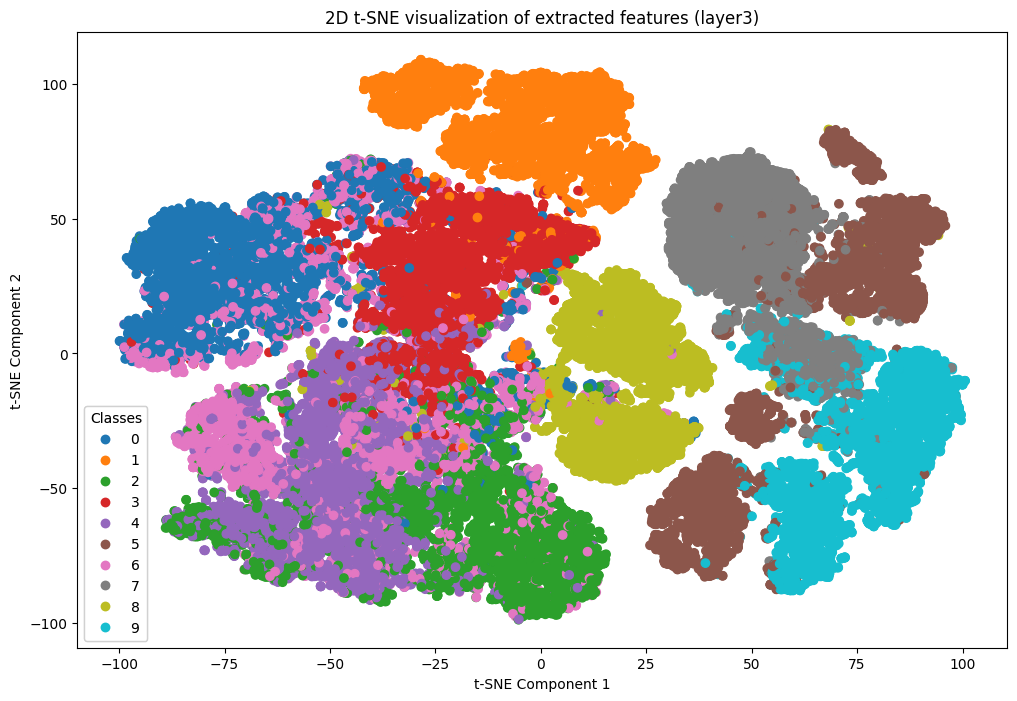

In [82]:
# Flatten the features
features_l3 = features_l3.reshape(features_l3.shape[0], -1)

# Optionally reduce dimensionality with PCA before t-SNE
pca = PCA(n_components=50)
features_l3_pca = pca.fit_transform(features_l3)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_l3_tsne = tsne.fit_transform(features_l3_pca)

# Plot the t-SNE results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(features_l3_tsne[:, 0], features_l3_tsne[:, 1], c=labels_l3, cmap='tab10')
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)


plt.title("2D t-SNE visualization of extracted features (layer3)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

plt.show()

In [138]:
t_intra_class_var_l3, t_mean_intra_l3 = intra_class_variance(features_l3_tsne, labels_l3)
pair_inter_l4 = inter_class_variance_tsne(features_l3_tsne, labels_l3)
print(f"Intra-Class Variance: {t_intra_class_var_l3}")
print(f"Mean of intra-class variance: {t_mean_intra_l3}")
for (label1, label2), variance in pair_inter_l4.items():
    print(f"Inter-class Variance between class {label1} and class {label2}: {variance:.4f}")

Intra-Class Variance: [2820.688, 2190.1694, 1048.7175, 910.3642, 509.80215, 2491.82, 1334.4037, 446.81805, 496.31042, 3601.409]
Mean of intra-class variance: [-18.631838, 38.79259, -41.20969, 3.9268787, -45.76425, 29.954546, -31.98846, 42.62712, 4.6343985, 18.393398]
Inter-class Variance between class 0 and class 1: 1261.2296
Inter-class Variance between class 0 and class 2: 1887.7366
Inter-class Variance between class 0 and class 3: 687.9674
Inter-class Variance between class 0 and class 4: 1232.4932
Inter-class Variance between class 0 and class 5: 3179.4111
Inter-class Variance between class 0 and class 6: 1073.1193
Inter-class Variance between class 0 and class 7: 2183.2031
Inter-class Variance between class 0 and class 8: 1506.3936
Inter-class Variance between class 0 and class 9: 3534.8997
Inter-class Variance between class 1 and class 2: 3103.3394
Inter-class Variance between class 1 and class 3: 718.8273
Inter-class Variance between class 1 and class 4: 2635.3086
Inter-class Va

In [137]:
pairwise_mean_diff_l3 = pairwise_intra_mean_diff(t_mean_intra_l3)
for (label1, label2), variance in pairwise_mean_diff_l3.items():
    print(f"Mean Difference between class {label1} and class {label2}: {variance:.4f}")

Mean Difference between class 0 and class 1: 57.4244
Mean Difference between class 0 and class 2: 22.5779
Mean Difference between class 0 and class 3: 22.5587
Mean Difference between class 0 and class 4: 27.1324
Mean Difference between class 0 and class 5: 48.5864
Mean Difference between class 0 and class 6: 13.3566
Mean Difference between class 0 and class 7: 61.2590
Mean Difference between class 0 and class 8: 23.2662
Mean Difference between class 0 and class 9: 37.0252
Mean Difference between class 1 and class 2: 80.0023
Mean Difference between class 1 and class 3: 34.8657
Mean Difference between class 1 and class 4: 84.5568
Mean Difference between class 1 and class 5: 8.8380
Mean Difference between class 1 and class 6: 70.7811
Mean Difference between class 1 and class 7: 3.8345
Mean Difference between class 1 and class 8: 34.1582
Mean Difference between class 1 and class 9: 20.3992
Mean Difference between class 2 and class 3: 45.1366
Mean Difference between class 2 and class 4: 4.5

In [140]:
pairwise_fscore_l3 = pairwise_inter_class_variance(features_l3_tsne, labels_l3)

for (label1, label2), (variance, p_value) in pairwise_fscore_l3.items():
    print(f"F-statistic between class {label1} and class {label2}: {variance:.4f}, p_value: {p_value:.4f}")

F-statistic between class 0 and class 1: 125.8459, p_value: 0.1315
F-statistic between class 0 and class 2: 367.8786, p_value: 0.1556
F-statistic between class 0 and class 3: 71.7430, p_value: 0.3361
F-statistic between class 0 and class 4: 459.4481, p_value: 0.2446
F-statistic between class 0 and class 5: 469.2185, p_value: 0.2343
F-statistic between class 0 and class 6: 62.6175, p_value: 0.3712
F-statistic between class 0 and class 7: 327.9753, p_value: 0.2595
F-statistic between class 0 and class 8: 398.9070, p_value: 0.1542
F-statistic between class 0 and class 9: 393.2114, p_value: 0.0702
F-statistic between class 1 and class 2: 439.0841, p_value: 0.2385
F-statistic between class 1 and class 3: 79.4457, p_value: 0.2610
F-statistic between class 1 and class 4: 277.6763, p_value: 0.0924
F-statistic between class 1 and class 5: 137.7662, p_value: 0.1290
F-statistic between class 1 and class 6: 141.2359, p_value: 0.1691
F-statistic between class 1 and class 7: 133.7779, p_value: 0.119

Residual block: layer 4 (excluded average pooling layer and fully connected layer)

In [127]:
resnet_l4 = nn.Sequential(*list(resnet.children())[:-2])
# Extract features
features = []
labels = []

resnet_l4.eval()
with torch.no_grad():
    for images, lbls in test_data_loader:
        images = images.to(device)
        outputs = resnet_l4(images) 
        features.append(outputs.cpu().numpy())
        labels.append(lbls.cpu().numpy())

In [128]:
features = np.concatenate(features, axis=0)
labels= np.concatenate(labels, axis=0)

In [129]:
intra_class_var_l4, mean_intra_l4 = intra_class_variance(features, labels)
inter_class_var_l4 = inter_class_variance(features, labels)

print(f"Intra-Class Variance: {intra_class_var_l4}")
print(f"Mean of intra-class variance: {mean_intra_l4}")
print(f"Mean of Inter-Class Variance: {inter_class_var_l4}")


Intra-Class Variance: [1.9669662, 1.9268748, 1.8327844, 1.8845258, 2.0287132, 1.6799697, 1.8959513, 1.6973499, 2.0003548, 1.9014634]
Mean of intra-class variance: [0.7546342, 0.655247, 0.7569475, 0.68545884, 0.7937991, 0.6588215, 0.7554164, 0.6526118, 0.7848171, 0.72755265]
Inter-Class Variance: 0.33081305027008057


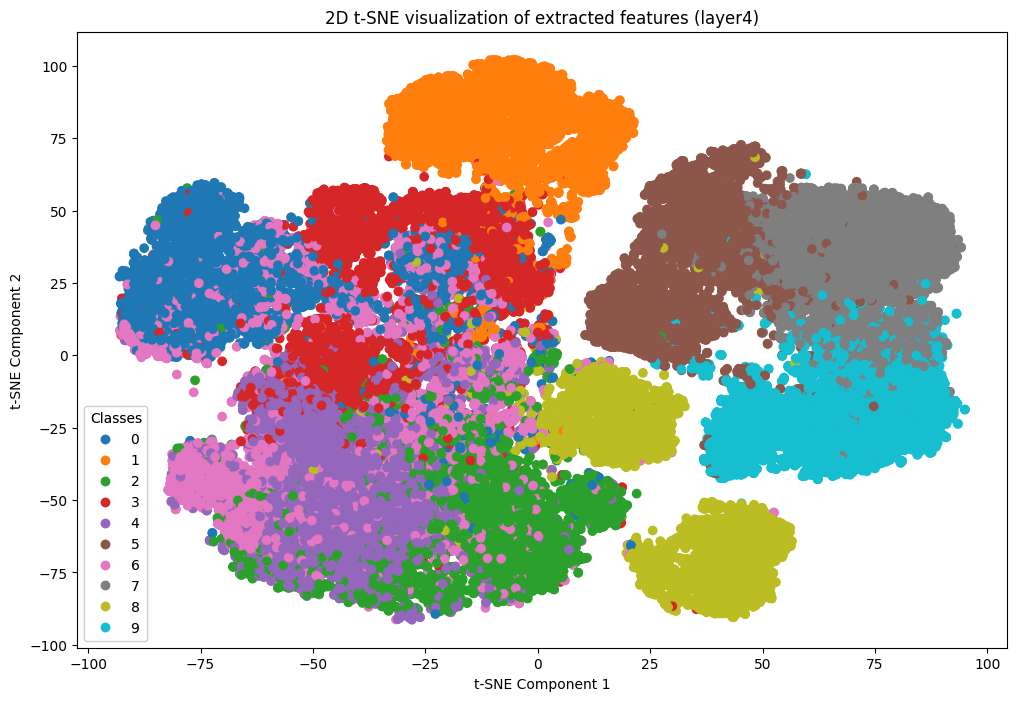

In [130]:
# Flatten the features
features = features.reshape(features.shape[0], -1)

pca = PCA(n_components=50)
features_pca_l4 = pca.fit_transform(features)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_tsne_l4 = tsne.fit_transform(features_pca_l4)

# Plot the t-SNE results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(features_tsne_l4[:, 0], features_tsne_l4[:, 1], c=labels, cmap='tab10')
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)


plt.title("2D t-SNE visualization of extracted features (layer4)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

plt.show()

In [131]:
t_intra_class_var_l4, t_mean_intra_l4 = intra_class_variance(features_tsne_l4, labels) 
t_inter_class_var_l4= inter_class_variance(features_tsne_l4, labels)
pair_wise_l4 = inter_class_variance_tsne(features_tsne_l4, labels)
print(f"Intra-Class Variance: {t_intra_class_var_l4}")
print(f"Mean of intra-class variance: {t_mean_intra_l4}")
for (label1, label2), variance in pair_wise_l4.items():
    print(f"Inter-class Variance between class {label1} and class {label2}: {variance:.4f}")

Intra-Class Variance: [2292.743, 1914.9983, 884.93115, 1172.7275, 370.5316, 273.4174, 1072.0112, 627.9096, 1913.2422, 2030.3231]
Mean of intra-class variance: [-17.994389, 35.191597, -34.628746, -3.2111058, -43.888447, 32.63526, -30.979462, 51.266697, -9.395333, 22.460276]
Inter-class Variance between class 0 and class 1: 1085.5304
Inter-class Variance between class 0 and class 2: 1544.8032
Inter-class Variance between class 0 and class 3: 598.6526
Inter-class Variance between class 0 and class 4: 1078.0590
Inter-class Variance between class 0 and class 5: 1500.9585
Inter-class Variance between class 0 and class 6: 950.7275
Inter-class Variance between class 0 and class 7: 2543.4175
Inter-class Variance between class 0 and class 8: 2116.4883
Inter-class Variance between class 0 and class 9: 2570.5769
Inter-class Variance between class 1 and class 2: 2516.2500
Inter-class Variance between class 1 and class 3: 759.3482
Inter-class Variance between class 1 and class 4: 2306.0034
Inter-cla

In [133]:
pairwise_mean_diff_l4 = pairwise_intra_mean_diff(t_mean_intra_l4)

for (label1, label2), variance in pairwise_mean_diff_l4.items():
    print(f"Mean Difference between class {label1} and class {label2}: {variance:.4f}")

Mean Difference between class 0 and class 1: 53.1860
Mean Difference between class 0 and class 2: 16.6344
Mean Difference between class 0 and class 3: 14.7833
Mean Difference between class 0 and class 4: 25.8941
Mean Difference between class 0 and class 5: 50.6297
Mean Difference between class 0 and class 6: 12.9851
Mean Difference between class 0 and class 7: 69.2611
Mean Difference between class 0 and class 8: 8.5991
Mean Difference between class 0 and class 9: 40.4547
Mean Difference between class 1 and class 2: 69.8203
Mean Difference between class 1 and class 3: 38.4027
Mean Difference between class 1 and class 4: 79.0800
Mean Difference between class 1 and class 5: 2.5563
Mean Difference between class 1 and class 6: 66.1711
Mean Difference between class 1 and class 7: 16.0751
Mean Difference between class 1 and class 8: 44.5869
Mean Difference between class 1 and class 9: 12.7313
Mean Difference between class 2 and class 3: 31.4176
Mean Difference between class 2 and class 4: 9.2

In [134]:
pairwise_fscore_l4 = pairwise_inter_class_variance(features_tsne_l4, labels)

for (label1, label2), (variance, p_value) in pairwise_fscore_l4.items():
    print(f"F-statistic between class {label1} and class {label2}: {variance:.4f}, p_value: {p_value:.4f}")

F-statistic between class 0 and class 1: 142.5902, p_value: 0.1346
F-statistic between class 0 and class 2: 259.2957, p_value: 0.1571
F-statistic between class 0 and class 3: 56.0250, p_value: 0.4076
F-statistic between class 0 and class 4: 85.1160, p_value: 0.2447
F-statistic between class 0 and class 5: 234.7389, p_value: 0.2702
F-statistic between class 0 and class 6: 35.5220, p_value: 0.3735
F-statistic between class 0 and class 7: 752.8731, p_value: 0.2546
F-statistic between class 0 and class 8: 3637.1640, p_value: 0.0891
F-statistic between class 0 and class 9: 297.9468, p_value: 0.0854
F-statistic between class 1 and class 2: 313.5553, p_value: 0.2545
F-statistic between class 1 and class 3: 86.6438, p_value: 0.2279
F-statistic between class 1 and class 4: 275.7136, p_value: 0.0908
F-statistic between class 1 and class 5: 92.9123, p_value: 0.1313
F-statistic between class 1 and class 6: 129.0147, p_value: 0.1664
F-statistic between class 1 and class 7: 208.9460, p_value: 0.0749

The whole resnet18 model as feature extractor:

In [142]:
# Extract features
features = []
labels = []

resnet.eval()
with torch.no_grad():
    for images, lbls in test_data_loader:
        images = images.to(device)
        outputs = resnet(images)
        features.append(outputs.cpu().numpy())
        labels.append(lbls.cpu().numpy())


In [143]:
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)



In [148]:
intra_class_var, mean_intra = intra_class_variance(features, labels)
inter_class_var = inter_class_variance(features, labels)

print(f"Intra-Class Variance: {intra_class_var}")
print(f"Mean of Inter-Class Variance: {inter_class_var}")

Intra-Class Variance: [8.814977, 8.565485, 9.238724, 8.212694, 9.399037, 6.147154, 9.008737, 6.265587, 9.1629095, 7.7218947]
Mean of Inter-Class Variance: 0.7026450634002686


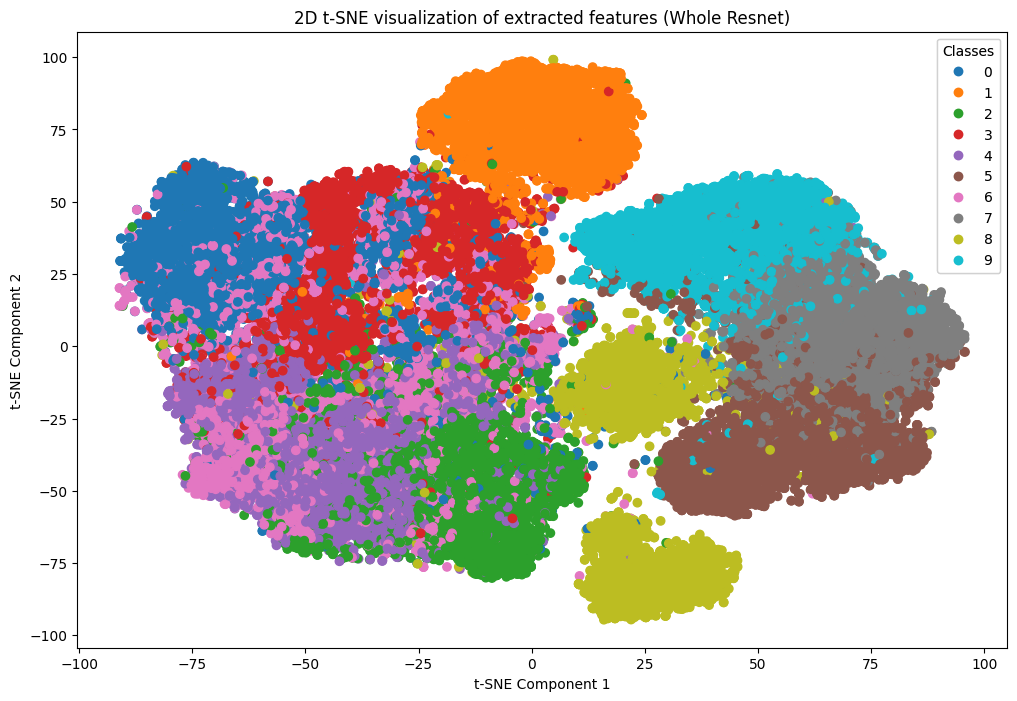

In [144]:
# Flatten the features
features = features.reshape(features.shape[0], -1)

# # Apply t-SNE to the chosen channel features
# tsne = TSNE(n_components=2, random_state=42)
# features_tsne = tsne.fit_transform(features)

# Optionally reduce dimensionality with PCA before t-SNE
pca = PCA(n_components=50)
features_pca = pca.fit_transform(features)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_pca)

# Plot the t-SNE results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='tab10')
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)


plt.title("2D t-SNE visualization of extracted features (Whole Resnet)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

plt.show()

In [135]:
intra_class_var, mean_intra = intra_class_variance(features_tsne, labels)
pair_wise = inter_class_variance_tsne(features_tsne, labels)

print(f"Intra-Class Variance: {intra_class_var}")
print(f"Mean of intra-class variance: {mean_intra}")
for (label1, label2), variance in pair_wise.items():
    print(f"Inter-class Variance between class {label1} and class {label2}: {variance:.4f}")

Intra-Class Variance: [2413.0583, 1511.6747, 618.7925, 1234.3274, 426.7062, 2237.011, 1094.686, 1231.5421, 1870.5487, 212.02759]
Mean of intra-class variance: [-14.154361, 37.129192, -31.307102, -3.0831575, -38.102806, 11.402692, -25.5449, 36.575092, -11.262445, 39.189507]
Inter-class Variance between class 0 and class 1: 1037.2729
Inter-class Variance between class 0 and class 2: 1382.5991
Inter-class Variance between class 0 and class 3: 560.8014
Inter-class Variance between class 0 and class 4: 955.1561
Inter-class Variance between class 0 and class 5: 2488.1619
Inter-class Variance between class 0 and class 6: 915.6522
Inter-class Variance between class 0 and class 7: 2434.3354
Inter-class Variance between class 0 and class 8: 2124.4875
Inter-class Variance between class 0 and class 9: 1603.9421
Inter-class Variance between class 1 and class 2: 2121.8926
Inter-class Variance between class 1 and class 3: 735.9026
Inter-class Variance between class 1 and class 4: 1944.6580
Inter-clas

In [123]:
pairwise_variances = pairwise_intra_mean_diff(mean_intra)

for (label1, label2), variance in pairwise_variances.items():
    print(f"Mean Difference between class {label1} and class {label2}: {variance:.4f}")


Mean Difference between class 0 and class 1: 51.2836
Mean Difference between class 0 and class 2: 17.1527
Mean Difference between class 0 and class 3: 11.0712
Mean Difference between class 0 and class 4: 23.9484
Mean Difference between class 0 and class 5: 25.5571
Mean Difference between class 0 and class 6: 11.3905
Mean Difference between class 0 and class 7: 50.7295
Mean Difference between class 0 and class 8: 2.8919
Mean Difference between class 0 and class 9: 53.3439
Mean Difference between class 1 and class 2: 68.4363
Mean Difference between class 1 and class 3: 40.2123
Mean Difference between class 1 and class 4: 75.2320
Mean Difference between class 1 and class 5: 25.7265
Mean Difference between class 1 and class 6: 62.6741
Mean Difference between class 1 and class 7: 0.5541
Mean Difference between class 1 and class 8: 48.3916
Mean Difference between class 1 and class 9: 2.0603
Mean Difference between class 2 and class 3: 28.2239
Mean Difference between class 2 and class 4: 6.79

In [146]:
pairwise_variances = pairwise_inter_class_variance(features_tsne, labels)

for (label1, label2), (variance, p_value) in pairwise_variances.items():
    print(f"F-statistic between class {label1} and class {label2}: {variance:.4f}, p_value: {p_value:.4f}")


F-statistic between class 0 and class 1: 162.3815, p_value: 0.1376
F-statistic between class 0 and class 2: 162.7855, p_value: 0.1647
F-statistic between class 0 and class 3: 3469.4223, p_value: 0.4194
F-statistic between class 0 and class 4: 59.5404, p_value: 0.2743
F-statistic between class 0 and class 5: 627.4867, p_value: 0.0725
F-statistic between class 0 and class 6: 37.9756, p_value: 0.3730
F-statistic between class 0 and class 7: 297.8110, p_value: 0.1613
F-statistic between class 0 and class 8: 318.9561, p_value: 0.1026
F-statistic between class 0 and class 9: 196.7742, p_value: 0.2597
F-statistic between class 1 and class 2: 225.6842, p_value: 0.2060
F-statistic between class 1 and class 3: 72.9683, p_value: 0.1835
F-statistic between class 1 and class 4: 168.3052, p_value: 0.0832
F-statistic between class 1 and class 5: 429.8752, p_value: 0.0490
F-statistic between class 1 and class 6: 213.1554, p_value: 0.1538
F-statistic between class 1 and class 7: 1913.4763, p_value: 0.0